# Using Reddit's API for Predicting Comments 
## Project 3: Caitlin Streamer
### Personal Website: https://caitlinstreamer.wordpress.com/portfolio/hot-or-not-creating-popular-reddit-posts/

## Step 1: Scraping Thread Info from Reddit.com

In [1]:
# Import libraries for the whole notebook 
import requests
import json
import pandas as pd
import numpy as np
from time import sleep
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as datetime
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Define URL and get request from Reddit
URL = "http://www.reddit.com/hot.json"
res = requests.get(URL, headers = {'User-agent':'Caitlin Bot 0.1'})

In [3]:
# Convert API response into a dictionary 
data = res.json()

In [4]:
# Inspect the hierarchy of the json dictionary 
data.keys()

dict_keys(['kind', 'data'])

In [5]:
# Data key value is a dictionary with a children key -- where all the post information is 
data['data'].keys()

dict_keys(['modhash', 'dist', 'children', 'after', 'before'])

In [6]:
# Number of top posts in intial scrape - 25
print(len(data['data']['children']))

25


In [7]:
# Create dictionary from first 25 posts, including a column for the time the data was scraped 
red = [child['data'] for child in data['data']['children']]
red = pd.DataFrame(red)
time = pd.Timestamp.utcnow()
red['time fetched'] = time
red.head()

,approved_at_utc,approved_by,archived,author,author_flair_css_class,author_flair_template_id,author_flair_text,banned_at_utc,banned_by,can_gild,...,thumbnail_width,title,ups,url,user_reports,view_count,visited,whitelist_status,wls,time fetched
0,None,None,False,Cigs_in_side,None,None,None,None,None,False,...,140.0,Child for sale,15615,https://i.redd.it/nyenf6bxxd111.jpg,[],None,False,promo_all,5,2018-06-01 15:58:07.690979+00:00
1,None,None,False,unknown_human,None,None,None,None,None,False,...,140.0,Conan at a pub in Belfast yesterday (x-post /r...,21938,https://i.imgur.com/jxSdMv2.gifv,[],None,False,all_ads,6,2018-06-01 15:58:07.690979+00:00
2,None,None,False,mahoudeerqueen,None,None,None,None,None,False,...,140.0,My grandma visited his store and asked if he e...,21812,https://i.redd.it/ttt1j3jsnd111.jpg,[],None,False,all_ads,6,2018-06-01 15:58:07.690979+00:00
3,None,None,False,4noop,None,None,None,None,None,False,...,140.0,[Image] Never Give Up,11093,https://i.imgur.com/ouIEw7a.gifv,[],None,False,all_ads,6,2018-06-01 15:58:07.690979+00:00
4,None,None,False,ScaryChicken,None,None,None,None,None,False,...,140.0,"Two lions, two tigers and a jaguar have report...",30261,https://bbc.in/2LfjZHd,[],None,False,all_ads,6,2018-06-01 15:58:07.690979+00:00


In [8]:
# Inspect number of rows and columns 
red.shape

(25, 84)

In [9]:
# Inspect column names 
red.columns

Index(['approved_at_utc', 'approved_by', 'archived', 'author',
       'author_flair_css_class', 'author_flair_template_id',
       'author_flair_text', 'banned_at_utc', 'banned_by', 'can_gild',
       'can_mod_post', 'clicked', 'contest_mode', 'created', 'created_utc',
       'crosspost_parent', 'crosspost_parent_list', 'distinguished', 'domain',
       'downs', 'edited', 'gilded', 'hidden', 'hide_score', 'id',
       'is_crosspostable', 'is_reddit_media_domain', 'is_self', 'is_video',
       'likes', 'link_flair_css_class', 'link_flair_text', 'locked', 'media',
       'media_embed', 'media_only', 'mod_note', 'mod_reason_by',
       'mod_reason_title', 'mod_reports', 'name', 'no_follow', 'num_comments',
       'num_crossposts', 'num_reports', 'over_18', 'parent_whitelist_status',
       'permalink', 'pinned', 'post_categories', 'post_hint', 'preview',
       'previous_visits', 'pwls', 'quarantine', 'removal_reason',
       'report_reasons', 'saved', 'score', 'secure_media',
       'sec

In [10]:
# Scrape thousands of posts using method above - compile into a dataframe 
next_post = data['data']['after']
for i in range(0,80):
    URL = "http://www.reddit.com/hot.json?after=" + next_post
    res = requests.get(URL, headers = {'User-agent':'Caitlin Bot 0.1'})
    post = res.json()
    time_now = pd.Timestamp.utcnow()
    next_post = post['data']['after']
    post_df = [child['data'] for child in post['data']['children']]
    post_df = pd.DataFrame(post_df)
    red = pd.concat([red, post_df], ignore_index = True)
    red['time fetched'] = time_now
    sleep(1)
red.head()

,approved_at_utc,approved_by,archived,author,author_cakeday,author_flair_css_class,author_flair_template_id,author_flair_text,banned_at_utc,banned_by,...,thumbnail_width,time fetched,title,ups,url,user_reports,view_count,visited,whitelist_status,wls
0,None,None,False,Cigs_in_side,NaN,None,None,None,None,None,...,140.0,2018-06-01 16:00:17.555776+00:00,Child for sale,15615,https://i.redd.it/nyenf6bxxd111.jpg,[],None,False,promo_all,5.0
1,None,None,False,unknown_human,NaN,None,None,None,None,None,...,140.0,2018-06-01 16:00:17.555776+00:00,Conan at a pub in Belfast yesterday (x-post /r...,21938,https://i.imgur.com/jxSdMv2.gifv,[],None,False,all_ads,6.0
2,None,None,False,mahoudeerqueen,NaN,None,None,None,None,None,...,140.0,2018-06-01 16:00:17.555776+00:00,My grandma visited his store and asked if he e...,21812,https://i.redd.it/ttt1j3jsnd111.jpg,[],None,False,all_ads,6.0
3,None,None,False,4noop,NaN,None,None,None,None,None,...,140.0,2018-06-01 16:00:17.555776+00:00,[Image] Never Give Up,11093,https://i.imgur.com/ouIEw7a.gifv,[],None,False,all_ads,6.0
4,None,None,False,ScaryChicken,NaN,None,None,None,None,None,...,140.0,2018-06-01 16:00:17.555776+00:00,"Two lions, two tigers and a jaguar have report...",30261,https://bbc.in/2LfjZHd,[],None,False,all_ads,6.0


In [11]:
# Inspect compiled dictionary 
red.shape

(2025, 85)

In [12]:
# Look at 4 features: title, subreddit, num_comments, and created_utc
red_4 = red[['title', 'subreddit', 'num_comments', 'created_utc', 'id', 'time fetched']].copy(deep = True)
red_4.head()

,title,subreddit,num_comments,created_utc,id,time fetched
0,Child for sale,BlackPeopleTwitter,345,1.527857e+09,8nrl15,2018-06-01 16:00:17.555776+00:00
1,Conan at a pub in Belfast yesterday (x-post /r...,gifs,892,1.527854e+09,8nrb34,2018-06-01 16:00:17.555776+00:00
2,My grandma visited his store and asked if he e...,OldSchoolCool,466,1.527854e+09,8nr8ut,2018-06-01 16:00:17.555776+00:00
3,[Image] Never Give Up,GetMotivated,321,1.527857e+09,8nrlvu,2018-06-01 16:00:17.555776+00:00
4,"Two lions, two tigers and a jaguar have report...",news,1817,1.527851e+09,8nr18g,2018-06-01 16:00:17.555776+00:00


In [13]:
# Convert created_utc to readable format
red_4['created_utc'] = red_4['created_utc'].astype('datetime64[s]')
red_4['time fetched'] = red_4['time fetched'].astype('datetime64[s]')
red_4.head()

,title,subreddit,num_comments,created_utc,id,time fetched
0,Child for sale,BlackPeopleTwitter,345,2018-06-01 12:44:10,8nrl15,2018-06-01 16:00:17
1,Conan at a pub in Belfast yesterday (x-post /r...,gifs,892,2018-06-01 11:58:29,8nrb34,2018-06-01 16:00:17
2,My grandma visited his store and asked if he e...,OldSchoolCool,466,2018-06-01 11:47:25,8nr8ut,2018-06-01 16:00:17
3,[Image] Never Give Up,GetMotivated,321,2018-06-01 12:47:48,8nrlvu,2018-06-01 16:00:17
4,"Two lions, two tigers and a jaguar have report...",news,1817,2018-06-01 11:07:23,8nr18g,2018-06-01 16:00:17


In [14]:
# Create an Age feature: time fetched - created
red_4['age'] = red_4['time fetched'] - red_4['created_utc']

In [15]:
# Drop created and time fetched columns - age takes their place 
red_4.drop(['created_utc', 'time fetched'], axis = 1, inplace = True)

In [16]:
# Convert age into hours and inspect head of scrape 
red_4['age'] = red_4['age'].astype('timedelta64[h]')
red_4.head()

,title,subreddit,num_comments,id,age
0,Child for sale,BlackPeopleTwitter,345,8nrl15,3.0
1,Conan at a pub in Belfast yesterday (x-post /r...,gifs,892,8nrb34,4.0
2,My grandma visited his store and asked if he e...,OldSchoolCool,466,8nr8ut,4.0
3,[Image] Never Give Up,GetMotivated,321,8nrlvu,3.0
4,"Two lions, two tigers and a jaguar have report...",news,1817,8nr18g,4.0


In [17]:
# Check for missing data - none
red_4.isna().sum()

title           0
subreddit       0
num_comments    0
id              0
age             0
dtype: int64

In [18]:
# Inspect data types
red_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2025 entries, 0 to 2024
Data columns (total 5 columns):
title           2025 non-null object
subreddit       2025 non-null object
num_comments    2025 non-null int64
id              2025 non-null object
age             2025 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 79.2+ KB


In [19]:
# Inspect maximum number of comments in the recent scrape 
red_4['num_comments'].max()

16776

## Step 2: Save Reddit data as a CSV

In [20]:
# Create filename based on current time 
current_time = datetime.datetime.now()
date = (  str(current_time.year)+'_'+
            str(current_time.month)+'_'+
            str(current_time.day)+'_'+
            str(current_time.hour)+'_'+
            str(current_time.minute))
filename = 'Reddit_Posts' + date + '.csv'
filename

'Reddit_Posts2018_6_1_9_3.csv'

In [21]:
# Export to csv
red_4.to_csv(filename)

## Step 3: EDA and Feature Engineering

In [22]:
# Load the data of the scraped results 
reddit = pd.read_csv(filename)
reddit.drop('Unnamed: 0', axis = 1, inplace = True)
reddit.head()

,title,subreddit,num_comments,id,age
0,Child for sale,BlackPeopleTwitter,345,8nrl15,3.0
1,Conan at a pub in Belfast yesterday (x-post /r...,gifs,892,8nrb34,4.0
2,My grandma visited his store and asked if he e...,OldSchoolCool,466,8nr8ut,4.0
3,[Image] Never Give Up,GetMotivated,321,8nrlvu,3.0
4,"Two lions, two tigers and a jaguar have report...",news,1817,8nr18g,4.0


In [23]:
# Inspect data types 
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2025 entries, 0 to 2024
Data columns (total 5 columns):
title           2025 non-null object
subreddit       2025 non-null object
num_comments    2025 non-null int64
id              2025 non-null object
age             2025 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 79.2+ KB


In [24]:
# Inspect numeric feature summary statistics 
reddit.describe()

,num_comments,age
count,2025.000000,2025.000000
mean,106.168395,8.028148
std,464.264448,5.714960
min,0.000000,0.000000
25%,10.000000,3.000000
50%,24.000000,6.000000
75%,71.000000,12.000000
max,16776.000000,24.000000


In [25]:
# Calculate median number of comments 
median_comments = reddit['num_comments'].median()
median_comments

24.0

I want to predict a binary variable - whether the number of comments was low or high. I will create a new binary variable that is true when the number of comments is high (above the median) or low (below the median). 

In [26]:
# Create new column defining high: # comments > median and low: # comments < median 
reddit['Class_comments'] = reddit.apply(lambda x: 'High' if x['num_comments'] > median_comments else 'Low', axis = 1)
reddit.head()

,title,subreddit,num_comments,id,age,Class_comments
0,Child for sale,BlackPeopleTwitter,345,8nrl15,3.0,High
1,Conan at a pub in Belfast yesterday (x-post /r...,gifs,892,8nrb34,4.0,High
2,My grandma visited his store and asked if he e...,OldSchoolCool,466,8nr8ut,4.0,High
3,[Image] Never Give Up,GetMotivated,321,8nrlvu,3.0,High
4,"Two lions, two tigers and a jaguar have report...",news,1817,8nr18g,4.0,High


I am compiling a master scrape dataframe from several days worth of scraping that might lead to a better model if there are trends in the posts that effect the number of comments. 

In [28]:
# Add recent scrape to master scrape
reddit_master = pd.read_csv('Reddit_Posts.csv')
for csv in ['Reddit_Posts2018_5_25_20_9.csv','Reddit_Posts2018_5_26_10_24.csv', 'Reddit_Posts2018_5_28_10_20.csv',
            'Reddit_Posts2018_5_29_12_48.csv', 'Reddit_Posts2018_5_29_19_11.csv', 
            'Reddit_Posts2018_5_30_10_46.csv', 'Reddit_Posts2018_5_31_11_8.csv', 'Reddit_Posts2018_6_1_9_3.csv']:
    new_red = pd.read_csv(csv)
    reddit_master = pd.concat([reddit_master, new_red], ignore_index = True)

# Drop duplicate posts - keeping the most up to date copy (oldest)
reddit_master.drop_duplicates(subset = 'id', keep = 'last', inplace = True)
reddit_master.drop('Unnamed: 0', axis = 1, inplace = True)

# Calculate master median and assign high/low classes 
median_comments = reddit_master['num_comments'].median()
reddit_master['Class_comments'] = reddit_master.apply(lambda x: 'High' if x['num_comments'] > median_comments else 'Low', axis = 1)

In [29]:
# Inspect master size
reddit_master.shape

(15667, 6)

Determine the baseline accuracy score that my models should perform better than 

In [30]:
# Baseline accuracy for this model is percentage of low vs high in the train set
reddit_master['Class_comments'].value_counts()/reddit_master.shape[0]

Low     0.500734
High    0.499266
Name: Class_comments, dtype: float64

Baseline accuracy is the percentage of the majority class ('low'). Since I used the median to categorize the classes, one might expect that the split would be exactly 50/50. However in this case there must have been posts with exactly the median number of posts, which would be categorized as 'Low'.

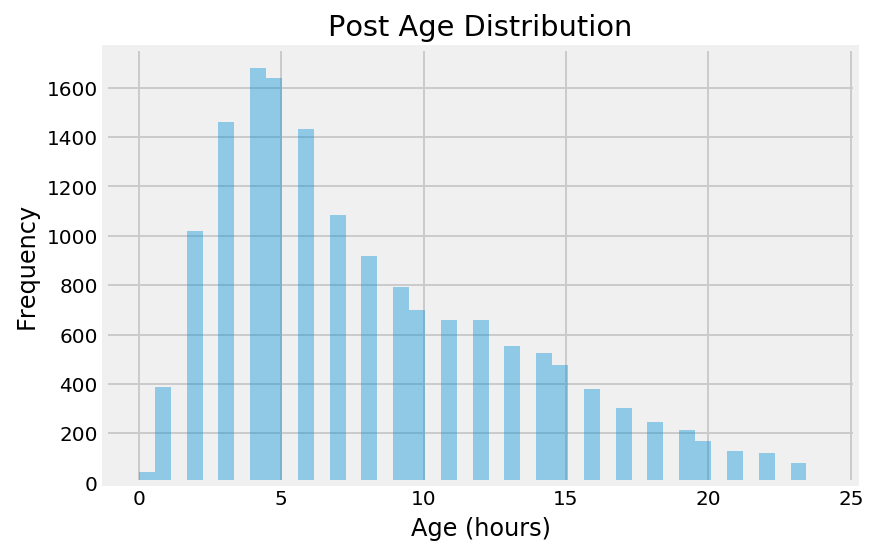

In [31]:
# Plot age distribution of master scrape - right skewed 
sns.distplot(reddit_master['age'], kde = False)
plt.xlabel("Age (hours)")
plt.ylabel('Frequency')
plt.title('Post Age Distribution');

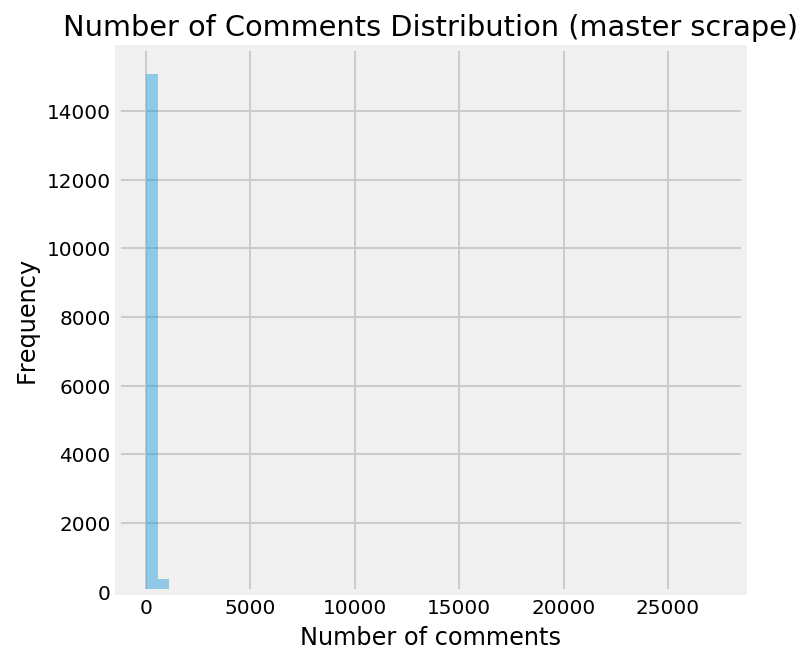

In [32]:
# Plot distribution of number of comments - master
fig = plt.figure(figsize = (5,5))
sns.distplot(reddit_master['num_comments'], kde = False)
plt.xlabel("Number of comments")
plt.ylabel('Frequency')
plt.title('Number of Comments Distribution (master scrape)');

Number of comments is skewed right. There are very few posts with comments in the thousands. What makes these few posts so popular? 

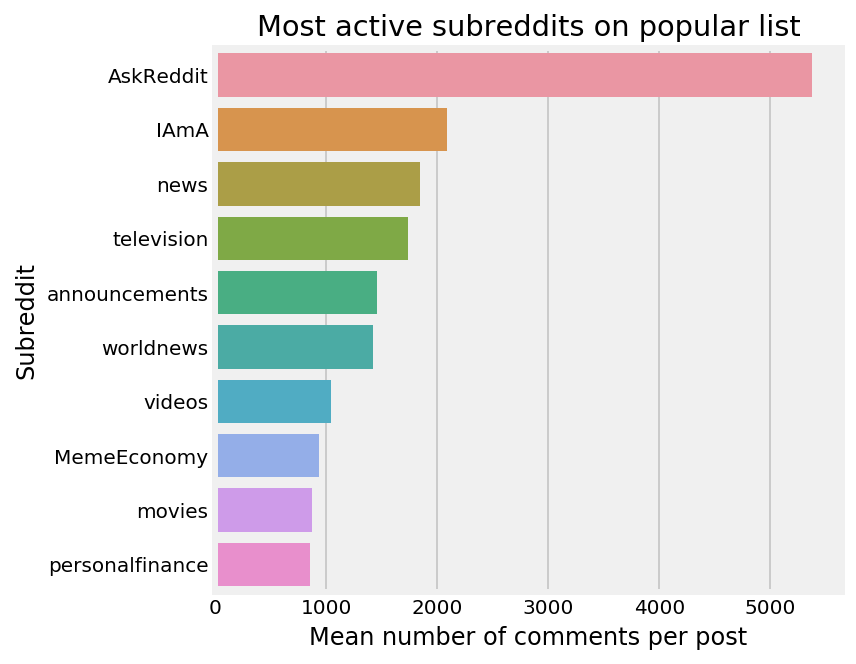

In [33]:
# Calculate mean number of comments per subreddit to identify high activity groups  
mean_sub_com = reddit_master.groupby('subreddit').agg({'num_comments': 'mean'})
top_mean_sub_com = mean_sub_com.sort_values('num_comments', ascending = False)

# Plot top 15 subreddits based on mean number of comments per post 
fig = plt.figure(figsize = (5,5))
sns.barplot(x = top_mean_sub_com['num_comments'].head(10), y = top_mean_sub_com.head(10).index)
plt.xlabel('Mean number of comments per post')
plt.ylabel('Subreddit')
plt.title('Most active subreddits on popular list');

## Step 4: Modeling and Model Evaluation

### Tree Based Models 

I will look at the following NLP and tree based classification combinations with various features  

1) Features: Subreddit  
Preprocessing: Dummy  
Model: RandomForest, GridSearch RandomForest  

2) Features: Subreddit, IsCat, IsFunny
Preprocessing: Dummy  
Model: RandomForest, GridSearch RandomForest  

3) Features: Title, age, subreddit  
Preprocessing: CountVector title, dummy subreddit  
Model: RandomForest, GridSearch RandomForest, and DecisionTreeClassifier    

#### Model with Subreddit feature

In [34]:
# Define X and y
X = reddit_master['subreddit']
y = reddit_master['Class_comments'].apply(lambda x: 1 if x == 'High' else 0)

X = pd.get_dummies(X, drop_first = True)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [35]:
# Random Forest Model 
rf = RandomForestClassifier(n_estimators = 30)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7383535417996171

In [36]:
# Model is very overfit since the test score is much lower than the train score 
rf.score(X_train, y_train)

0.8032099215757796

In [37]:
# Gridsearch model above to reduce overfitting 
rf = RandomForestClassifier()
rf_params = { 
    'min_samples_split': range(2,5),
    'n_estimators': [30, 35, 40]
}
gs = GridSearchCV(rf, param_grid=rf_params)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.7171256611344154
{'min_samples_split': 3, 'n_estimators': 30}


In [38]:
# Test score is better than the train score - model generalizes well 
gs.score(X_test, y_test)

0.7323973622633482

The tuned gridsearched model has a slighly better score than the default model. It does not suffer from overfitting like the untuned randfomforest model. 

#### Model with subreddit and new features 

In [39]:
# Create a new features, IsCat IsFunny, that is 1 if there is cat/funny in the title and 0 if there is not 
X = reddit_master[['title', 'subreddit']].copy(deep = True)
y = reddit_master['Class_comments'].apply(lambda x: 1 if x == 'High' else 0)

# Define IsCat column and dummy subreddits
X['IsCat'] = X['title'].map(lambda x: 1 if 'cat' in x else 0)
X['IsFunny'] = X['title'].map(lambda x: 1 if 'funny' in x else 0)
X.drop('title', axis = 1, inplace = True)
X = pd.get_dummies(X, drop_first = True)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [44]:
# Random Forest Model 
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7164433099340566

In [45]:
# Model is very overfit since the test score is much lower than the train score 
rf.score(X_train, y_train)

0.8050337406529272

In [41]:
# Gridsearch model above to reduce overfitting 
rf = RandomForestClassifier()
rf_params = { 
    'min_samples_split': range(2,5),
    'n_estimators': [30, 100, 150]
}
gs = GridSearchCV(rf, param_grid=rf_params)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.7232354550428598
{'min_samples_split': 3, 'n_estimators': 100}


In [43]:
# Test score is better than the train score - model generalizes well 
gs.score(X_test, y_test)

0.7219740480748776

It would appear that having Cat or Funny in the title does not improve the model when compared to the subreddit only model. The tuned model here has the same score, but is not overfit like the base randomforest model. The tuned model generalizes much better. 

#### Model with title, age, and subreddit

In [46]:
# Look at all 3 features: title, subreddit, and age
X = reddit_master[['title', 'age', 'subreddit']].copy(deep = True)
y = reddit_master['Class_comments'].apply(lambda x: 1 if x == 'High' else 0)

# Dummy subreddit 
X = pd.get_dummies(X, columns = ['subreddit'], drop_first = True)

# Train / Test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Define function to make sure features are the same in both the train and test 
def feature_check(train, test):
    missing_cols = set(train.columns) - set(test.columns)
    for c in missing_cols:
        test[c] = 0
    test = test[train.columns]
    return test

# TVEC fit transform only on title 
tvec = TfidfVectorizer(stop_words='english')
X_train_counts = pd.DataFrame(tvec.fit_transform(X_train['title']).todense(),
                              columns = ['t_' + w for w in tvec.get_feature_names()], index = X_train.index)
X_test_counts = pd.DataFrame(tvec.transform(X_test['title']).todense(),
                             columns = ['t_' + w for w in tvec.get_feature_names()], index = X_test.index)
                              
# Concat X_train_counts with X_train.drop(title)
X_train_total = pd.concat([X_train_counts, X_train.drop('title', axis =1)], axis =1)
X_test_total = pd.concat([X_test_counts, X_test.drop('title', axis =1)], axis =1)
                              
# Apply feature_check to make sure train and test have the same features
X_test_total_checked = feature_check(X_train_total, X_test_total)

# Random Forest Model 
rf = RandomForestClassifier()
rf.fit(X_train_total, y_train)
rf.score(X_test_total_checked, y_test)

0.7094235269091682

In [47]:
# Model is very overfit since the test score is much lower than the train score 
rf.score(X_train_total, y_train)

0.97391938719679

In [48]:
# Gridsearch model above to reduce overfitting 
rf = RandomForestClassifier()
rf_params = { 'max_depth': [60, 80],
    'min_samples_split': range(3,5),
    'n_estimators': [25, 35, 40]
}
gs = GridSearchCV(rf, param_grid=rf_params)
gs.fit(X_train_total, y_train)
gs.best_score_, gs.best_params_

(0.7111982491336859,
 {'max_depth': 80, 'min_samples_split': 4, 'n_estimators': 40})

In [49]:
# Test score is better than the train score - model generalizes well 
gs.score(X_test_total, y_test)

0.7068708785364816

In [50]:
# Decision Tree Model
tree = DecisionTreeClassifier(criterion='gini')
model = tree.fit(X_train_total, y_train)
model.score(X_test_total_checked, y_test)

0.681344394809615

Adding title and age features decreased the accuracy of the model. It would appear that subreddit is the most important feature when considering if a post will be highly commented. This makes sense since some subreddits have more activity and users than others. Here again, the tuned model has the same score as the base RF model, however it is not overfit. 

### Non-tree-based models

I will look at the following NLP and non-tree based classification combinations with various features 

1) Features: Age and Subreddit  
   Preprocessing: Dummy Subreddit names   
   Models: Multinomial Naive Bayes, Logistic Regression, and KNN
   
2) Features: Title  
   Preprocessing: TF-IDF, CountVectorizer  
   Models: Multinomial Naive Bayes, Logistic Regression  
   
3) Features: Title, Age, and Subreddit  
   Preprocessing: TF-IDF Title, Dummy Subreddit  
   Models: Logistic Regression, Multinomial Naive Bayes, and KNN



#### Models Using Age and Subreddit Features

In [51]:
# Look at Subreddit and Age features only 
# Define X and y
X = reddit_master[['age', 'subreddit']].copy(deep=True)
y = reddit_master['Class_comments'].apply(lambda x: 1 if x == 'High' else 0)

In [52]:
# Dummy subreddit values 
X = pd.get_dummies(X, drop_first = True)
X.head()

,age,subreddit_1200isjerky,subreddit_13ReasonsWhy,subreddit_13or30,subreddit_1500isplenty,subreddit_195,subreddit_2healthbars,subreddit_2mad4madlads,subreddit_2meirl42meirl4meirl,subreddit_2meirl4meirl,...,subreddit_ynab,subreddit_youdontsurf,subreddit_yourmomshousepodcast,subreddit_youseeingthisshit,subreddit_youtube,subreddit_youtubehaiku,subreddit_yuruyuri,subreddit_zelda,subreddit_zerocarb,subreddit_zuckmemes
2,4.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,6.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,6.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,6.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
# Train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [54]:
# Multinomial NB model on age and subreddit 
nb = MultinomialNB()
nb.fit(X_train, y_train)
nb.score(X_test, y_test)

0.7415443522654754

In [55]:
# Logistic Regression on age and subreddit 
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

0.7668581152946181

In [56]:
# Identify top predictors (highest odds ratio value from logreg coefficients) 
coefs = pd.DataFrame(logreg.coef_[0], index = X.columns, columns = ['coef'])
coefs['coef'] = np.exp(coefs['coef'])
coefs.sort_values(by='coef', ascending = False, inplace=True)
coefs.head(10)

,coef
subreddit_gaming,22.200089
subreddit_FortNiteBR,19.306270
subreddit_funny,18.213889
subreddit_pics,16.981885
subreddit_todayilearned,15.269482
subreddit_news,13.326791
subreddit_worldnews,12.642102
subreddit_videos,11.219796
subreddit_BlackPeopleTwitter,11.174288
subreddit_MemeEconomy,10.960296


In [57]:
# KNN model 
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.706019995745586

Logistic regression performed the best with age and subreddit features. 

#### Model Using Title Feature

In [58]:
# Try Multinomial Naive Bayes model with TF-IDF

# Define X and y
X = reddit_master['title']
y = reddit_master['Class_comments'].apply(lambda x: 1 if x == 'High' else 0)

# Train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [59]:
# Set up pipeline for TF-IDF and Multinomial NB
tvec = TfidfVectorizer(stop_words='english')
nb = MultinomialNB()
nb_pipe = Pipeline([('tvec', tvec), ('nb', nb)])

In [60]:
# Fit pipeline 
nb_pipe.fit(X_train, y_train)
nb_pipe.score(X_test, y_test)

0.5603063178047224

In [61]:
# Set up pipeline for CountVectorizer and Multinomial NB
cvec = CountVectorizer(stop_words='english')
nb = MultinomialNB()
nb_pipe_2 = Pipeline([('cvec', cvec), ('nb', nb)])

In [62]:
# Fit pipeline 
nb_pipe_2.fit(X_train, y_train)
nb_pipe_2.score(X_test, y_test)

0.5651988938523719

Count and TF-IDF performed nearly the same. Like Count, TF-IDF weights words based on frequency, however common words are penalized while rare words have more influence. 

In [63]:
# Define X and y
X = reddit_master['title']
y = reddit_master['Class_comments'].apply(lambda x: 1 if x == 'High' else 0)

In [64]:
# Train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [65]:
# Set up pipeline for CountVectorizer and Logistic Regression 
cvec = CountVectorizer(stop_words = 'english')
lr = LogisticRegression()
lr_pipe = Pipeline([('cvec', cvec), ('lr', lr)])

In [66]:
# Fit pipeline 
lr_pipe.fit(X_train, y_train)
lr_pipe.score(X_test, y_test)

0.5669006594341629

In [67]:
# Identify top predictors (highest odds ratio value from logreg coefficients) 
coefs = pd.DataFrame(lr_pipe.named_steps['lr'].coef_[0], index = lr_pipe.named_steps['cvec'].get_feature_names(),
                     columns = ['coef'])
coefs['coef'] = np.exp(coefs['coef'])
coefs.sort_values(by='coef', ascending = False, inplace=True)
coefs.head()

,coef
wcgw,7.829302
invest,5.154360
digital,4.956398
pencil,3.988778
banned,3.849364


Using title only as a feature results in very low accuracy rates (only slightly better than the baseline) 

#### Model Using Title, Age, and Subreddit Features

In [68]:
# Try Model above using master reddit dataframe 
# Look at all 3 features: title, subreddit, and age
X = reddit_master[['title', 'age', 'subreddit']].copy(deep = True)
y = reddit_master['Class_comments'].apply(lambda x: 1 if x == 'High' else 0)

# Dummy subreddit 
X = pd.get_dummies(X, columns = ['subreddit'], drop_first = True)

# Train / Test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# TVEC fit transform only on title 
tvec = TfidfVectorizer(stop_words='english')
X_train_counts = pd.DataFrame(tvec.fit_transform(X_train['title']).todense(),
                              columns = ['t_' + w for w in tvec.get_feature_names()], index = X_train.index)
X_test_counts = pd.DataFrame(tvec.transform(X_test['title']).todense(),
                             columns = ['t_' + w for w in tvec.get_feature_names()], index = X_test.index)
                              
# Concat X_train_counts with X_train.drop(title)
X_train_total = pd.concat([X_train_counts, X_train.drop('title', axis =1)], axis =1)
X_test_total = pd.concat([X_test_counts, X_test.drop('title', axis =1)], axis =1)
                              
# Apply feature_check to make sure train and test have the same features
X_test_total_checked = feature_check(X_train_total, X_test_total)

# Fit and score model
logreg = LogisticRegression(penalty = 'l2', C = 2.8)
logreg.fit(X_train_total, y_train)
logreg.score(X_test_total_checked, y_test)

0.7740906190172304

In [69]:
# Gridsearch on best logistic regression model above
lr_params = {'penalty':['l1', 'l2'], 
             'C': [2.3, 2.5, 2.6, 2.8,]}
gs = GridSearchCV(LogisticRegression(), param_grid = lr_params)
gs.fit(X_train_total, y_train)

# Results 
gs.best_score_, gs.best_params_

(0.7691956957869779, {'C': 2.6, 'penalty': 'l2'})

In [70]:
# Score gridsearch logreg model on test data
gs.score(X_test_total_checked, y_test)

0.7726015741331631

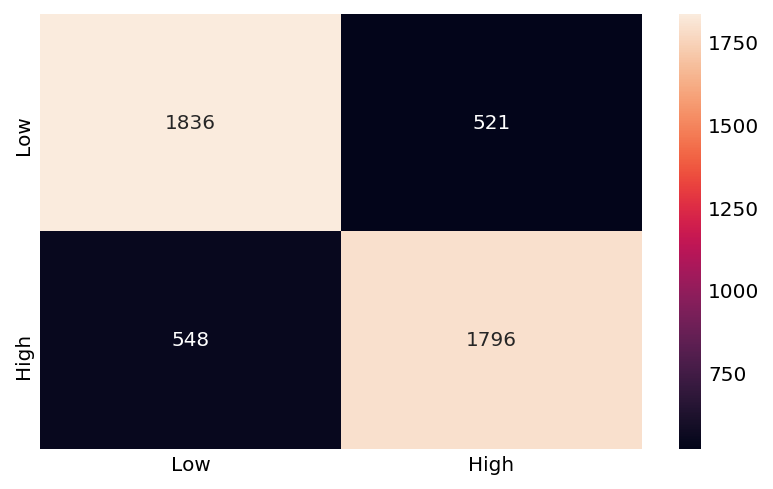

In [71]:
# Create a heatmap confusion matrix - get predictions 
predictions = gs.predict(X_test_total_checked)

# Create confusion matrix 
classes = ["Low", 'High']
cm = metrics.confusion_matrix(y_test, predictions)
cm = pd.DataFrame(cm, columns=classes)
cm.index = classes

# Plot matrix on heatmap 
sns.heatmap(cm, annot=True, fmt='g');

In [72]:
# Identify top predictors (highest odds ratio value from logreg coefficients) 
coefs = pd.DataFrame(gs.best_estimator_.coef_[0], index = X_train_total.columns, columns = ['coef'])
coefs['coef'] = np.exp(coefs['coef'])
coefs.sort_values(by='coef', ascending = False, inplace=True)
coefs.head(10)

,coef
subreddit_gaming,50.435407
subreddit_FortNiteBR,44.971332
subreddit_pics,43.913860
subreddit_funny,40.789127
subreddit_todayilearned,34.409061
subreddit_worldnews,25.873347
subreddit_news,23.766901
subreddit_trashy,23.339671
subreddit_BlackPeopleTwitter,23.045882
subreddit_europe,22.761012


In [73]:
# Determine post age odds ratio 
coefs.loc['age', :]

coef    1.307192
Name: age, dtype: float64

It appears that the subreddit is the strongest indicator for how popular the post will be. This makes sense since some subreddits have more followers and thus a higher activitiy than others. Since I also looked at age, with 1 hour increase in age, the post has a 30% increase in odds of having a higher number of posts. This also makes sense since more people will have time to view and comment on the post the longer its been posted. 

In [74]:
# MultinomialNB with same three features above
nb = MultinomialNB()
nb.fit(X_train_total, y_train)
nb.score(X_test_total_checked, y_test)

0.6787917464369283

In [75]:
# KNN model 
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_total, y_train)
knn.score(X_test_total_checked, y_test)

0.7034673473728994

Logistic regression had the best accuracy rate when compared to Naive Bayes, KNN, and tree based models. 

# Executive Summary


#### FiveThirtyEight Proposal -  Hot or Not: Creating Popular Reddit Posts  

FiveThirtyEight is a world leader in data journalism. By using statistical analysis, FiveThirtyEight publishes compelling stories in a variety of subjects. There is one subject, however, that has been largely absent from recent articles that surely deserves more attention: viral content. In the age of social media, content has never been easier to spread to the masses, so what exactly does it take to make attention grabbing posts on popular social media platforms?

In order to maintain a breadth of data driven stories that are relevant to its readers, FiveThirtyEight should consider topics that are common to their base. I'm proposing something that fits the bill: a story about how to create a popular post on the world's sixth most visited website, Reddit, backed by machine learning models.

By combining Natural Language Processing with machine learning, I was able to determine which characteristics of a Reddit post are most predictive of the overall interaction on a thread. By looking at features such as post title, subreddit, and age of the post, I was able to build a classification model that predicts if a post will have a high number of comments (defined as above the median number of comments) or low number (below the median). Not only does the model predict if a post will be popular based on these features, but it also gives insight into which features are most predictive.

Using Reddit's open source API, I scraped over 15,000 posts from the popular subreddit over a 7 day period. I utilized a Bag of Words NLP method, TF-IDF, with a tuned Logistic Regression machine learning classification model to predict whether a post will have a high or low number of comments. This model had a 77% accuracy rate and generalized well to new data. The top predictors were all popular subreddits: gaming, FortNiteBR, pics, funny and todayilearned. The odds of having a highly comment post in these subreddits is much higher since they have the most followers and higher overall activity.  

I share FiveThirtyEight's dedication to data driven journalism. I believe that an article on investigating viral social media content with NLP and Machine Learning would fit FiveThirtyEight's mission as well as be entertaining and informative to its readers. This proposal provides more details on my model, insights, and recommendations. I hope you find it enlightening and look forward to a possible partnership. 